In [1]:
from utils import *
import matplotlib.pyplot as plt
import time
from amf import *
from tri_ss import *
import warnings

warnings.filterwarnings('ignore')

We use as an example the economy from Bansal and Yaron (2004).
$$\begin{eqnarray}
x_{t+1}&=&\rho x_{t}+\mathrm{h}\varphi_{e}\sigma_{t}e_{t+1}\\\sigma_{t+1}^{2}&=&\sigma^{2}+\nu_{1}\left(\sigma_{t}^{2}-\sigma^{2}\right)+\mathrm{h}\sigma_{w}w_{t+1}\\c_{t+1}-c_{t}&=&\mu+x_{t}+\mathrm{h}\sigma_{t}\eta_{t+1}\\g_{t+1}-g_{t}&=&\mu_{d}+\phi x_{t}+\mathrm{h}\varphi_{d}\sigma_{t}u_{t+1}\\
\end{eqnarray}$$

where $x_t$ is the long-run expected growth, $\sigma_t$ is the stochastic volatility, $c_{t+1}-c_t$ is the logarithm of consumption growth, $g_{t+1}-g_t$ is the logarithm of dividend growth, and $e_{t+1},w_{t+1},\eta_{t+1},u_{t+1}\sim N\left(0,1\right)$. 

For simplicity, denote the state vector and shock vector as

$$
X_t = \left[\begin{array}{c} x_t\\ \sigma_t \end{array}\right], W_{t+1} = \left[\begin{array}{c}e_{t+1}\\ w_{t+1} \\ \eta_{t+1} \\ u_{t+1}\end{array}\right]
$$

In [2]:
ρ = 1.0000001
γ = 10
β = 0.998

In [3]:
ψ_x, ψ_w, ψ_q, ψ_xx, ψ_xw, ψ_xq, ψ_ww, ψ_wq, ψ_qq, \
    Γ_0_g, Γ_1_g, Γ_2_g, Γ_3_g, Ψ_0_g, Ψ_1_g, Ψ_2_g, \
    Γ_0_sg, Γ_1_sg, Γ_2_sg, Γ_3_sg, Ψ_0_sg, Ψ_1_sg, Ψ_2_sg = derivs_BY("C", ρ, γ, β)

The $\psi$ coefficients denote the derivatives of the state evolution function $X_{t+1} = \psi(X_t(q), qW_{t+1}, q)$.

We use $\mathscr{P}$ := $\left(\Gamma_i,\Psi_i\right)$ to denote the coefficients of the quadratic function

\begin{equation}
y_{t+1}-y_t = \Gamma_0 + \Gamma_1 X_t^1 + \Gamma_2 X_t^2 + \Gamma_3 \left(X_t^1 \otimes X_t^1\right) + \Psi_0W_{t+1} + \Psi_1 \left(X_t^1 \otimes W_{t+1}\right) + \Psi_2 \left(W_{t+1} \otimes W_{t+1}\right)\tag{1}
\end{equation}

$\mathscr{P}_{sg}$ will correspond to $y_{t+1}-y_t = s_{t+1} - s_t + c_{t+1} - c_t$ and $\mathscr{P}_g$ will correspond to $y_{t+1}-y_t = c_{t+1} - c_t$

In [4]:
𝒫_sg = (Γ_0_sg, Γ_1_sg, Γ_2_sg, Γ_3_sg, Ψ_0_sg, Ψ_1_sg, Ψ_2_sg)
𝒫_g = (Γ_0_g, Γ_1_g, Γ_2_g, Γ_3_g, Ψ_0_g, Ψ_1_g, Ψ_2_g)
perturbed_model_params = {
        'ψ_q': ψ_q,
        'ψ_x': ψ_x,
        'ψ_w': ψ_w,
        'ψ_qq': ψ_qq,
        'ψ_xq': ψ_xq,
        'ψ_x': ψ_x,
        'ψ_xx': ψ_xx,
        'ψ_wq': ψ_wq,
        'ψ_xw': ψ_xw,
        'ψ_ww': ψ_ww
        }
triss = map_perturbed_model_to_tri_ss(perturbed_model_params)
amf_sg = Amf(𝒫_sg, triss)
amf_g = Amf(𝒫_g, triss)

We can now compute elasticities as follows

In [5]:
def get_elasticities(amf_g, amf_sg, α_h, x, num_periods):
    """
    Compute shock exposure and price elasticities.
    
    Parameters:
    -----------
    amf_g: Amf object
        The amf object where Y_{t+1}/Y_t specifies growth rate only.
    amf_sg: Amf object
        The amf object where Y_{t+1}/Y_t specifies growth rate times SDF.
    α_h: ndarray(float, dim=1)
        A scalar specifying the shock for the elasticity.
    x: ndarray(float, dim=2)
        A vector of the first order approximation of the state.
    num_periods: integer
        The number of periods to calculate the elasticities.
        
    Returns:
    --------
    ϵ_g: ndarray(float, dim=1)
        A vector of exposure elasticities.
    ϵ_p: ndarray(float, dim=1)
        A vector of price elasticities.
    """
    ϵ_g = onp.zeros(num_periods - 1)
    ϵ_p = onp.zeros(num_periods - 1)

    for t in range(num_periods - 1):
        ϵ_g[t] = amf_g.ε(x, t + 1, α_h)
        ϵ_p[t] = amf_g.ε(x, t + 1, α_h) - amf_sg.ε(x, t + 1, α_h)
        
    return ϵ_g, ϵ_p

In [6]:
x = onp.array([[0,0]])

# Compute shock exposure and price elasticties to the first dimensional shock at mean states
ϵ_g, ϵ_p = get_elasticities(amf_g, amf_sg, onp.array([1, 0, 0, 0]), x, 100)

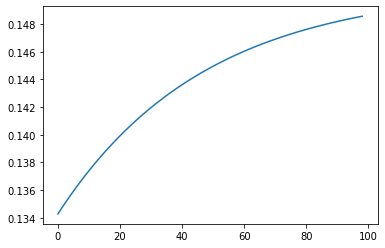

In [7]:
plt.plot(ϵ_p)
plt.show()